In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.spatial
from scipy.spatial.distance import cdist, pdist, squareform
import itertools
from itertools import product


In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))


In [2]:
def my_task(i1,i2,perc1,perc2,n, D1,D2,eps, batch_size,batch_ind,len_list):
    d=4
    D=D1+D2
    #print(str(i1)+':'+str(i2))
    #begin= time.time()

    # Data Generation
    np.random.seed(i1+i2*(len_list)+batch_ind*((len_list)**2))

    x1_coords = [0,1,4,5]
    x2_coords = [2,3,4,5]

    theta= np.random.rand(batch_size,n,3)*2*np.pi
    x= np.zeros((batch_size,n,6))
    x[:,:,0]= np.cos(theta[:,:,0])
    x[:,:,1]= np.sin(theta[:,:,0])
    x[:,:,2]= np.cos(theta[:,:,1])
    x[:,:,3]= np.sin(theta[:,:,1])
    x[:,:,4]= np.cos(theta[:,:,2])
    x[:,:,5]= np.sin(theta[:,:,2])

    del theta
    # sims X d X D 
    Q1_1 = np.random.randn(batch_size, d,perc1)/np.sqrt(D1)
    Q1_2 = np.random.randn(batch_size, d,perc2)/np.sqrt(D1)
    
    Q2_1 = np.random.randn(batch_size,d,D1-perc1)/np.sqrt(D-D1)
    Q2_2 = np.random.randn(batch_size,d,D2-perc2)/np.sqrt(D-D1)    
    
    # sims X n
    ######### select  ##########
    ################################ sims X d X d
    norm_select= (perc1+ perc2)/D

    Q1_metric= np.matmul(Q1_1, np.transpose(Q1_1,axes=[0,2,1]))/norm_select
    Q2_metric= np.matmul(Q1_2, np.transpose(Q1_2,axes=[0,2,1]))/norm_select
    ############################### batch X n x d    
    # sims X n X n
    
    norms = np.sum(np.matmul(x[:,:,x1_coords],Q1_metric)*x[:,:,x1_coords],axis=-1)   #1
    dist= norms[:,:,None]+ norms[:,None,:] -2*np.matmul(np.matmul(x[:,:,x1_coords],Q1_metric),\
                                                        np.transpose(x[:,:,x1_coords],[0,2,1]))  
    
    norms = np.sum(np.matmul(x[:,:,x2_coords],Q2_metric)*x[:,:,x2_coords],axis=-1)  
    dist += norms[:,:,None]+ norms[:,None,:] -2*np.matmul(np.matmul(x[:,:,x2_coords],Q2_metric),np.transpose(x[:,:,x2_coords],[0,2,1])) 

    expdist= np.exp(- dist[:,None,:,:]/(2*eps.reshape((1,-1,1,1))))
    expdist[:,:,np.arange(n), np.arange(n)]=0.
    
    res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
    
    ######### supp select  ##########
    ################################ 
    del Q1_metric, Q2_metric, dist,norms, expdist
    
    norm_supp= 1- norm_select
    
    Q1_metric= np.matmul(Q2_1, np.transpose(Q2_1,axes=[0,2,1]))/norm_supp
    Q2_metric= np.matmul(Q2_2, np.transpose(Q2_2,axes=[0,2,1]))/norm_supp
    ###############################    
    # sims X n X n
    norms = np.sum(np.matmul(x[:,:,x1_coords],Q1_metric)*x[:,:,x1_coords],axis=-1)  #2
    dist= norms[:,:,None]+ norms[:,None,:] -2*np.matmul(np.matmul(x[:,:,x1_coords],Q1_metric),np.transpose(x[:,:,x1_coords],[0,2,1]))  
    
    norms = np.sum(np.matmul(x[:,:,x2_coords],Q2_metric)*x[:,:,x2_coords],axis=-1)  
    dist += norms[:,:,None]+ norms[:,None,:] -2*np.matmul(np.matmul(x[:,:,x2_coords],Q2_metric),np.transpose(x[:,:,x2_coords],[0,2,1]))
    
    expdist= np.exp(- dist[:,None,:,:]/(2*eps.reshape((1,-1,1,1))))
    expdist[:,:,np.arange(n), np.arange(n)]=0.
    res += -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)

    del Q1_metric, Q2_metric, dist,norms, expdist
    del x, Q1_1,Q1_2,Q2_1,Q2_2
    #print(str(i1)+' took '+str(time.time()-begin))

    return res 

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import time

eps = np.logspace(-3,0,10)
batch_size=100
n=1000
D=10000
D1= D//4
D2=D-D1

perc1=np.arange(100,D1-100+1,25).astype(int) #np.arange(100,D1-100+1,10)
perc2=np.arange(100,D2-100+1,75).astype(int) #np.arange(100,D2-100+1,10)

#for batch_ind in range(1):
batch_ind=0
res= np.zeros((len(perc1),len(perc2), batch_size, len(eps)))
print('begin')
for i1 in range(len(perc1)):
    begin= time.time()
    with ProcessPoolExecutor() as executor:

        #Submit multiple instances of the same task function
        futures = [executor.submit(my_task,i1,i2,perc1[i1],perc2[i2],n,D1,D2, eps,batch_size,batch_ind, len_list=np.max([len(perc1),len(perc2)]) ) for i2 in range(len(perc2)) ]

        #Wait for all tasks to complete
        results = [future.result() for future in futures]

    res[i1,:,:,:]= np.array(results)
    print(str(i1)+' took '+str(time.time()-begin))
        

begin


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

0 took 467.95631217956543


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

1 took 351.80692625045776


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

2 took 337.6977014541626


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

3 took 303.7992627620697


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

4 took 305.327739238739


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

5 took 293.26244950294495


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

6 took 298.35249423980713


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

7 took 354.12230229377747


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

8 took 292.78278636932373


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

9 took 288.4957001209259


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

10 took 300.92787194252014


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

11 took 289.39981341362


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

12 took 290.240403175354


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

13 took 287.295937538147


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

27 took 292.58948612213135


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

28 took 276.45246267318726
29 took 277.897408246994


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

30 took 287.22226190567017


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

31 took 272.78545093536377


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

32 took 285.05543065071106


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

33 took 290.11660289764404


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

42 took 282.64097833633423


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

43 took 288.44856119155884


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

44 took 283.3072488307953


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

45 took 274.5203711986542


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

46 took 293.413254737854


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

47 took 274.71394205093384


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

48 took 283.2919683456421


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

49 took 294.3406422138214


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

50 took 304.31411957740784


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

51 took 283.68935561180115


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

52 took 275.9886565208435


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

53 took 301.6244943141937


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

54 took 278.48981761932373


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

55 took 278.3522071838379


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

56 took 274.60489153862


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

57 took 277.2351987361908


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

58 took 282.53310775756836


/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in log
  res = -np.mean(np.log(np.mean(expdist ,axis=-1 )),axis=-1)
/tmp/ipykernel_1351877/1836660921.py:50: RuntimeWarning: divide by zero encountered in l

In [313]:
indimc = 1
indim1=1
indim2=1
D=10000
eps = np.logspace(-3,0,10)

K=2

cur_eps_ind= -4
cur_eps= eps[cur_eps_ind]


D1=D//4
D2=D-D1

beta1=D1/D
beta2=D2/D

perc1_quarter=np.arange(100,D1-100+1,25).astype(int) 
perc2_quarter=np.arange(100,D2-100+1,75).astype(int)

p1_quarter = (perc1_quarter/D1).reshape((-1,1))
p2_quarter = (perc2_quarter/D2).reshape((1,-1))


p1= p1_quarter+0.
p2 = p2_quarter+0.

anal_res_quarter =  indimc/2*np.log((p1+p2)/(p1*beta1+p2*beta2))
anal_res_quarter += indimc/2*np.log((2-p1-p2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -K*indimc/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += indim1/2*np.log(p1*(1-p1)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += indim2/2*np.log(p2*(1-p2)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -K*indim1/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += -K*indim2/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += 3*K*np.log(2*np.pi)

In [314]:
2*cur_eps

np.float64(0.2)

0.1


Text(0.5, 0.98, 'Loss Landscape for the Analysis Section')

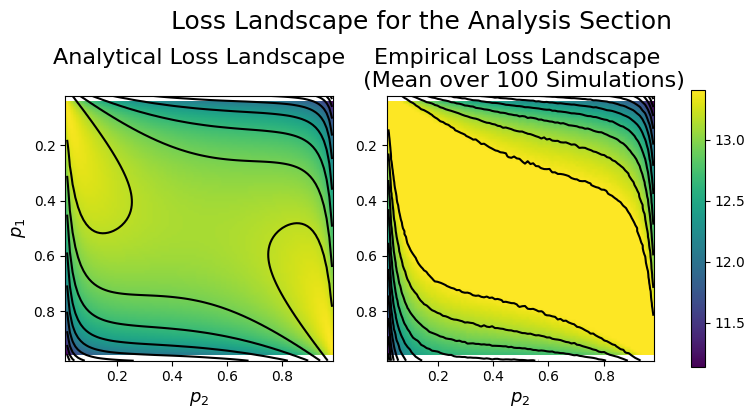

In [315]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(cur_eps)
amount_levs= 11

f,ax= plt.subplots(1,2,figsize=(9.5,4.5))


vmin_quarter=np.min([np.min(anal_res_quarter),np.min(np.mean(res[:,:,:,cur_eps_ind]))])
vmax_quarter=np.max([np.max(anal_res_quarter),np.max(np.mean(res[:,:,:,cur_eps_ind]))])

ax[0].imshow(anal_res_quarter,vmin=vmin_quarter,vmax=vmax_quarter,\
                   extent = [p2_quarter.flatten()[0],p2_quarter.flatten()[-1], p1_quarter.flatten()[-1], p1_quarter.flatten()[0]])
im2= ax[1].imshow(np.mean(res[:,:,:,cur_eps_ind],axis=-1),vmin=vmin_quarter,vmax=vmax_quarter,\
                   extent = [p2_quarter.flatten()[0],p2_quarter.flatten()[-1], p1_quarter.flatten()[-1], p1_quarter.flatten()[0]])


levels= np.linspace(vmin_quarter, vmax_quarter,amount_levs)

ax[0].contour(anal_res_quarter,levels=levels,\
                   extent = [p2_half.flatten()[0],p2_half.flatten()[-1], p1_half.flatten()[0], p1_half.flatten()[-1]],\
              vmin=vmin_quarter,vmax= vmax_quarter,colors='black')
ax[1].contour(np.mean(res[:,:,:,cur_eps_ind],axis=-1),levels=levels,\
                   extent = [p2_half.flatten()[0],p2_half.flatten()[-1], p1_half.flatten()[0], p1_half.flatten()[-1]],\
              colors='black')




cbar2 = plt.colorbar(im2, ax=ax, location='right', shrink=0.8)



for i in range(2):
    ax[i].set_xlabel('$p_2$',fontsize=13)
    
ax[0].set_ylabel('$p_1$',fontsize=13)

ax[0].set_title('Analytical Loss Landscape\n',fontsize=16)
ax[1].set_title('Empirical Loss Landscape \n (Mean over 100 Simulations)',fontsize=16)
plt.suptitle('Loss Landscape for the Analysis Section',fontsize=18)

In [310]:

indimc = 1
indim1=1
indim2=1
D=10000
eps = np.logspace(-3,0,10)

K=2

cur_eps_ind= -3
cur_eps= eps[cur_eps_ind]

D1=D//4
D2=D-D1

beta1=D1/D
beta2=D2/D

perc1_quarter=np.arange(100,D1-100+1,25).astype(int) #np.arange(100,D1-100+1,10)
perc2_quarter=np.arange(100,D2-100+1,75).astype(int) #np.arange(100,D2-100+1,10)

p1_quarter = (perc1_quarter/D1).reshape((-1,1))
p2_quarter = (perc2_quarter/D2).reshape((1,-1))


p1= p1_quarter+0.
p2 = p2_quarter+0.

anal_res_quarter =  indimc/2*np.log((p1+p2)/(p1*beta1+p2*beta2))
anal_res_quarter += indimc/2*np.log((2-p1-p2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -K*indimc/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += indim1/2*np.log(p1*(1-p1)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += indim2/2*np.log(p2*(1-p2)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -K*indim1/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += -K*indim2/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += 3*K*np.log(2*np.pi)

In [311]:
2*cur_eps

np.float64(0.43088693800637645)

0.21544346900318823


Text(0.5, 0.98, 'Objective Landscape for the Analysis Section')

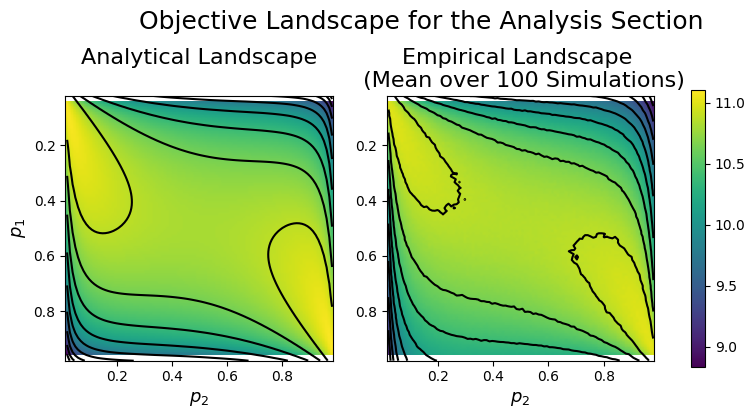

In [312]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(cur_eps)
amount_levs= 11

f,ax= plt.subplots(1,2,figsize=(9.5,4.5))


vmin_quarter=np.min([np.min(anal_res_quarter),np.min(np.mean(res[:,:,:,cur_eps_ind]))])
vmax_quarter=np.max([np.max(anal_res_quarter),np.max(np.mean(res[:,:,:,cur_eps_ind]))])

ax[0].imshow(anal_res_quarter,vmin=vmin_quarter,vmax=vmax_quarter,\
                   extent = [p2_quarter.flatten()[0],p2_quarter.flatten()[-1], p1_quarter.flatten()[-1], p1_quarter.flatten()[0]])
im2= ax[1].imshow(np.mean(res[:,:,:,cur_eps_ind],axis=-1),vmin=vmin_quarter,vmax=vmax_quarter,\
                   extent = [p2_quarter.flatten()[0],p2_quarter.flatten()[-1], p1_quarter.flatten()[-1], p1_quarter.flatten()[0]])


levels= np.linspace(vmin_quarter, vmax_quarter,amount_levs)
#levels= np.log(np.linspace(np.exp(vmin_quarter), np.exp(vmax_quarter),amount_levs))

ax[0].contour(anal_res_quarter,levels=levels,\
                   extent = [p2_half.flatten()[0],p2_half.flatten()[-1], p1_half.flatten()[0], p1_half.flatten()[-1]],\
              vmin=vmin_quarter,vmax= vmax_quarter,colors='black')
ax[1].contour(np.mean(res[:,:,:,cur_eps_ind],axis=-1),levels=levels,\
                   extent = [p2_half.flatten()[0],p2_half.flatten()[-1], p1_half.flatten()[0], p1_half.flatten()[-1]],\
              colors='black')


# cax = f.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]


cbar2 = plt.colorbar(im2, ax=ax, location='right',shrink=0.8)


for i in range(2):
    ax[i].set_xlabel('$p_2$',fontsize=13)
    
ax[0].set_ylabel('$p_1$',fontsize=13)


ax[0].set_title('Analytical Landscape\n',fontsize=16)
ax[1].set_title('Empirical Landscape \n (Mean over 100 Simulations)',fontsize=16)
plt.suptitle('Objective Landscape for the Analysis Section',fontsize=18)

# FP

In [161]:
from concurrent.futures import ProcessPoolExecutor
import time
from FP import *

def my_task_FP(x1,Q1,x2,Q2,perc1_part1,perc2_part1,perplexity=10):
    n= len(x1)
    dists= np.zeros((2,n,n))

    ##############
    metric1= Q1[:,:perc1_part1]@Q1[:,:perc1_part1].T
    inner_prod=  x1@ metric1@x1.T+0.
    dists[0]= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod
    
    metric2= Q2[:,:perc2_part1]@Q2[:,:perc2_part1].T
    inner_prod= x2@ metric2@x2.T+0.
    dists[0]+= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod

    ###############################
    
    metric1= Q1[:,perc1_part1:]@Q1[:,perc1_part1:].T
    inner_prod=  x1@ metric1@x1.T+0.
    dists[1]= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod
    
    metric2= Q2[:,perc2_part1:]@Q2[:,perc2_part1:].T
    inner_prod= x2@ metric2@x2.T+0.
    dists[1]+= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod
   ################################### 
    
    W= FP_get_W( dists, None,perplexity,is_x_sqrd_dists=True)
    return FP_get_val(dists, W,None,perplexity,is_x_sqrd_dists=True)

batch_size=100
n=1000
D=10000
D1= D//4
D2=D-D1

perc1=np.arange(100,D1-100+1,23*2).astype(int) 
perc2=np.arange(100,D2-100+1,73*2).astype(int) 


batch_ind=0

len_list= np.max([len(perc1),len(perc2)])
res_FP= np.zeros((len(perc1),len(perc2), batch_size))
print('begin')
for i1 in range(len(perc1)):
    print(str(i1)+'  '+str(len(perc1)))

    for i2 in range(len(perc2)):
        print(str(i2)+'  '+str(len(perc2)))

        d=4
        
        D=D1+D2
        
        # Data Generation
        np.random.seed(i1+i2*(len_list)+batch_ind*((len_list)**2))
    
        x1_coords = [0,1,4,5]
        x2_coords = [2,3,4,5]
    
        theta= np.random.rand(batch_size,n,3)*2*np.pi
        x= np.zeros((batch_size,n,6))
        x[:,:,0]= np.cos(theta[:,:,0])
        x[:,:,1]= np.sin(theta[:,:,0])
        x[:,:,2]= np.cos(theta[:,:,1])
        x[:,:,3]= np.sin(theta[:,:,1])
        x[:,:,4]= np.cos(theta[:,:,2])
        x[:,:,5]= np.sin(theta[:,:,2])
    
        del theta
        # sims X d X D 
        Q1 = np.random.randn(batch_size, d,D1)/np.sqrt(D1)
        Q2 = np.random.randn(batch_size, d,D2)/np.sqrt(D2)

        for i3 in range(batch_size):
            res_FP[i1,i2,i3]= my_task_FP(x[i3][:,x1_coords], Q1[i3], x[i3][:,x2_coords], Q2[i3], perc1[i1],perc2[i2])


begin
0  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  51
42  51
43  51
44  51
45  51
46  51
47  51
48  51
49  51
50  51
1  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  51
42  51
43  51
44  51
45  51
46  51
47  51
48  51
49  51
50  51
2  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  5

/usr/local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


45  51
46  51
47  51
48  51
49  51
50  51
21  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  51
42  51
43  51
44  51
45  51
46  51
47  51
48  51
49  51
50  51
22  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  51
42  51
43  51
44  51
45  51
46  51
47  51
48  51
49  51
50  51
23  51
0  51
1  51
2  51
3  51
4  51


KeyboardInterrupt: 

In [198]:
res_FP_mean= np.mean(res_FP,axis=-1)

In [200]:
p1_quarter_FP = (perc1/D1).reshape((-1,1))
p2_quarter_FP = (perc2/D2).reshape((1,-1))


Text(0, 0.5, '$p_1$')

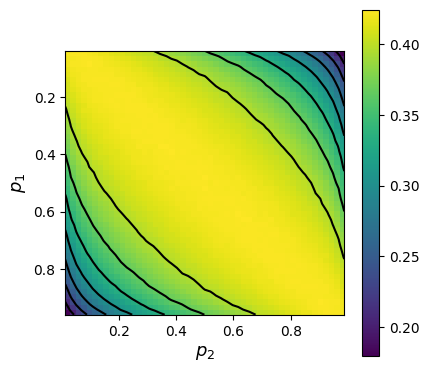

In [224]:
amount_levs= 9

plt.figure(figsize=(4.5,4.5))

vmin_FP=np.min(res_FP_mean)
vmax_FP=np.max(res_FP_mean)

im2= plt.imshow(res_FP_mean,vmin=vmin_FP,vmax=vmax_FP,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0]])

levels= np.log(np.linspace(np.exp(vmin_FP), np.exp(vmax_FP),amount_levs))

plt.contour(res_FP_mean,levels=levels,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0], p1_quarter_FP.flatten()[-1]],\
              vmin=vmin_FP,vmax= vmax_FP,colors='black')


cbar2 = plt.colorbar(im2, location='right')

plt.xlabel('$p_2$',fontsize=13)
    
plt.ylabel('$p_1$',fontsize=13)


# Perplxity 20

In [203]:
from concurrent.futures import ProcessPoolExecutor
import time
from FP import *

def my_task_FP(x1,Q1,x2,Q2,perc1_part1,perc2_part1,perplexity=10):
    n= len(x1)
    dists= np.zeros((2,n,n))

    ##############
    metric1= Q1[:,:perc1_part1]@Q1[:,:perc1_part1].T
    inner_prod=  x1@ metric1@x1.T+0.
    dists[0]= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod
    
    metric2= Q2[:,:perc2_part1]@Q2[:,:perc2_part1].T
    inner_prod= x2@ metric2@x2.T+0.
    dists[0]+= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod

    ###############################
    
    metric1= Q1[:,perc1_part1:]@Q1[:,perc1_part1:].T
    inner_prod=  x1@ metric1@x1.T+0.
    dists[1]= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod
    
    metric2= Q2[:,perc2_part1:]@Q2[:,perc2_part1:].T
    inner_prod= x2@ metric2@x2.T+0.
    dists[1]+= inner_prod[np.arange(n),np.arange(n)][:,None]+\
            inner_prod[np.arange(n),np.arange(n)][None,:] -2*inner_prod
   ################################### 
    
    W= FP_get_W( dists, None,perplexity,is_x_sqrd_dists=True)
    return FP_get_val(dists, W,None,perplexity,is_x_sqrd_dists=True)


perplexity=20
batch_size=100
n=1000
D=10000
D1= D//4
D2=D-D1

perc1=np.arange(100,D1-100+1,23*2).astype(int) 
perc2=np.arange(100,D2-100+1,73*2).astype(int) 

#for batch_ind in range(1):
batch_ind=0

len_list= np.max([len(perc1),len(perc2)])
res_FP_20= np.zeros((len(perc1),len(perc2), batch_size))
print('begin')
for i1 in range(len(perc1)):
    print(str(i1)+'  '+str(len(perc1)))

    for i2 in range(len(perc2)):
        print(str(i2)+'  '+str(len(perc2)))

        d=4
        
        D=D1+D2
        
        # Data Generation
        np.random.seed(i1+i2*(len_list)+batch_ind*((len_list)**2))
    
        x1_coords = [0,1,4,5]
        x2_coords = [2,3,4,5]
    
        theta= np.random.rand(batch_size,n,3)*2*np.pi
        x= np.zeros((batch_size,n,6))
        x[:,:,0]= np.cos(theta[:,:,0])
        x[:,:,1]= np.sin(theta[:,:,0])
        x[:,:,2]= np.cos(theta[:,:,1])
        x[:,:,3]= np.sin(theta[:,:,1])
        x[:,:,4]= np.cos(theta[:,:,2])
        x[:,:,5]= np.sin(theta[:,:,2])
    
        del theta
        # sims X d X D 
        Q1 = np.random.randn(batch_size, d,D1)/np.sqrt(D1)
        Q2 = np.random.randn(batch_size, d,D2)/np.sqrt(D2)

        for i3 in range(batch_size):
            res_FP_20[i1,i2,i3]= my_task_FP(x[i3][:,x1_coords], Q1[i3], x[i3][:,x2_coords], Q2[i3], perc1[i1],perc2[i2], perplexity)




begin
0  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  51
42  51
43  51
44  51
45  51
46  51
47  51
48  51
49  51
50  51
1  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  51
42  51
43  51
44  51
45  51
46  51
47  51
48  51
49  51
50  51
2  51
0  51
1  51
2  51
3  51
4  51
5  51
6  51
7  51
8  51
9  51
10  51
11  51
12  51
13  51
14  51
15  51
16  51
17  51
18  51
19  51
20  51
21  51
22  51
23  51
24  51
25  51
26  51
27  51
28  51
29  51
30  51
31  51
32  51
33  51
34  51
35  51
36  51
37  51
38  51
39  51
40  51
41  5

In [218]:
res_FP_20_mean= np.mean(res_FP_20,axis=-1)

In [220]:
p1_quarter_FP = (perc1/D1).reshape((-1,1))
p2_quarter_FP = (perc2/D2).reshape((1,-1))

Text(0, 0.5, '$p_1$')

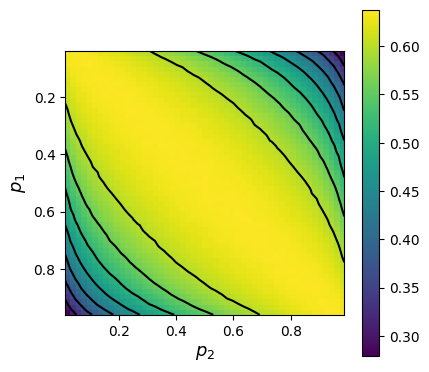

In [222]:
amount_levs= 9

plt.figure(figsize=(4.5,4.5))

vmin_FP=np.min(res_FP_20_mean)
vmax_FP=np.max(res_FP_20_mean)

im2= plt.imshow(res_FP_20_mean,vmin=vmin_FP,vmax=vmax_FP,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0]])


levels= np.log(np.linspace(np.exp(vmin_FP), np.exp(vmax_FP),amount_levs))

plt.contour(res_FP_20_mean,levels=levels,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0], p1_quarter_FP.flatten()[-1]],\
              vmin=vmin_FP,vmax= vmax_FP,colors='black')


cbar2 = plt.colorbar(im2, location='right')

plt.xlabel('$p_2$',fontsize=13)
    
plt.ylabel('$p_1$',fontsize=13)


Text(0.5, 1.0, 'Perplexity=20')

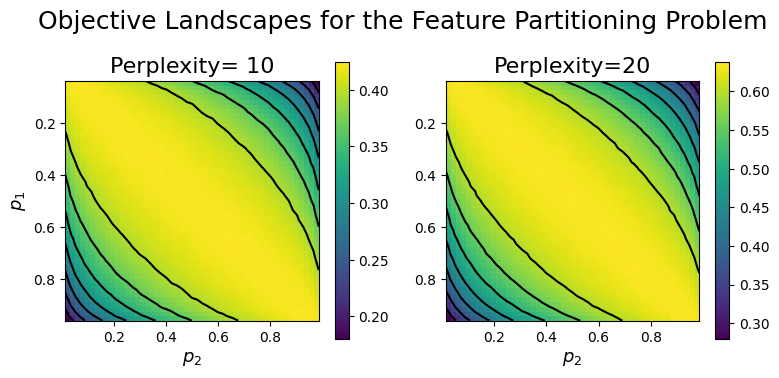

In [317]:
amount_levs= 9

f,ax= plt.subplots(1,2,figsize=(9,4.5))

######################
vmin_FP=np.min(res_FP_mean)
vmax_FP=np.max(res_FP_mean)

im2= ax[0].imshow(res_FP_mean,vmin=vmin_FP,vmax=vmax_FP,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0]])

levels= np.log(np.linspace(np.exp(vmin_FP), np.exp(vmax_FP),amount_levs))

ax[0].contour(res_FP_mean,levels=levels,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0], p1_quarter_FP.flatten()[-1]],\
              vmin=vmin_FP,vmax= vmax_FP,colors='black')

cbar2 = f.colorbar(im2,ax= ax[0],  location='right', shrink=0.8)

#########################################
vmin_FP=np.min(res_FP_20_mean)
vmax_FP=np.max(res_FP_20_mean)

im2= ax[1].imshow(res_FP_20_mean,vmin=vmin_FP,vmax=vmax_FP,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0]])

levels= np.log(np.linspace(np.exp(vmin_FP), np.exp(vmax_FP),amount_levs))

ax[1].contour(res_FP_20_mean,levels=levels,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0], p1_quarter_FP.flatten()[-1]],\
              vmin=vmin_FP,vmax= vmax_FP,colors='black')

cbar2 = f.colorbar(im2,ax= ax[1],  location='right', shrink=0.8)
############################
for i in range(2):
    ax[i].set_xlabel('$p_2$',fontsize=13)
    
ax[0].set_ylabel('$p_1$',fontsize=13)

plt.suptitle('Objective Landscapes for the Feature Partitioning Problem',fontsize=18,y=.92)
ax[0].set_title('Perplexity= 10',fontsize=16)
ax[1].set_title('Perplexity=20',fontsize=16)

Text(0.5, 1.0, 'Objective Landscape for the \n Feature Partitioning Problem \n (Mean over 100 Simulations)')

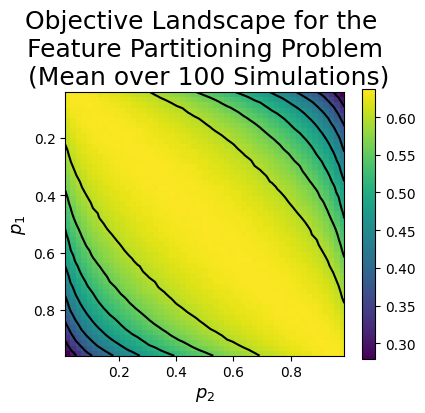

In [324]:
amount_levs= 9

f,ax= plt.subplots(1,1,figsize=(4.5,4.5))

#########################################
vmin_FP=np.min(res_FP_20_mean)
vmax_FP=np.max(res_FP_20_mean)

im2= ax.imshow(res_FP_20_mean,vmin=vmin_FP,vmax=vmax_FP,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0]])

levels= np.log(np.linspace(np.exp(vmin_FP), np.exp(vmax_FP),amount_levs))

ax.contour(res_FP_20_mean,levels=levels,\
                   extent = [p2_quarter_FP.flatten()[0],p2_quarter_FP.flatten()[-1], p1_quarter_FP.flatten()[0], p1_quarter_FP.flatten()[-1]],\
              vmin=vmin_FP,vmax= vmax_FP,colors='black')

cbar2 = f.colorbar(im2,ax= ax,  location='right', shrink=0.78)
############################
ax.set_xlabel('$p_2$',fontsize=13)
    
ax.set_ylabel('$p_1$',fontsize=13)

plt.title('Objective Landscape for the \n Feature Partitioning Problem \n (Mean over 100 Simulations)',fontsize=18)


# analysis

In [249]:
indimc = 1
indim1=1
indim2=1
D=10000
eps = np.logspace(-3,0,10)

K=2

cur_eps_ind= -4
cur_eps= eps[cur_eps_ind]


In [250]:
D1=D//4
D2=D-D1

beta1=D1/D
beta2=D2/D

perc1_quarter=np.arange(100,D1-100+1,25).astype(int)
perc2_quarter=np.arange(100,D2-100+1,75).astype(int)

p1_quarter = (perc1_quarter/D1).reshape((-1,1))
p2_quarter = (perc2_quarter/D2).reshape((1,-1))


p1= p1_quarter+0.
p2 = p2_quarter+0.

anal_res_quarter =  indimc/2*np.log((p1+p2)/(p1*beta1+p2*beta2))
anal_res_quarter += indimc/2*np.log((2-p1-p2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -K*indimc/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += indim1/2*np.log(p1*(1-p1)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += indim2/2*np.log(p2*(1-p2)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -K*indim1/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += -K*indim2/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += 3*K*np.log(2*np.pi)

In [33]:
D1=D//2
D2= D-D1

beta1=D1/D
beta2=D2/D

perc1_half=np.arange(100,D1-100+1,50).astype(int)
perc2_half=np.arange(100,D2-100+1,50).astype(int)

p1_half = (perc1_half/D1).reshape((-1,1))
p2_half = (perc2_half/D2).reshape((1,-1))


p1= p1_half+0.
p2 = p2_half+0.
anal_res_half =  2*cur_eps*indimc/2*np.log((p1+p2)/(p1*beta1+p2*beta2))
anal_res_half += 2*cur_eps*indimc/2*np.log((2-p1-p2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_half += -2*cur_eps*K*indimc/2*np.log(2*np.pi*cur_eps)
anal_res_half += 2*cur_eps*indim1/2*np.log(p1*(1-p1)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_half += 2*cur_eps*indim2/2*np.log(p2*(1-p2)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_half += -2*cur_eps*K*indim1/2*np.log(2*np.pi*cur_eps)
anal_res_half += -2*cur_eps*K*indim2/2*np.log(2*np.pi*cur_eps)
anal_res_half += 3*2*cur_eps*K*np.log(2*np.pi)

In [ ]:
D1=D//4
D2=D-D1

beta1=D1/D
beta2=D2/D

perc1_quarter=np.arange(100,D1-100+1,25).astype(int)
perc2_quarter=np.arange(100,D2-100+1,75).astype(int)

p1_quarter = (perc1_quarter/D1).reshape((-1,1))
p2_quarter = (perc2_quarter/D2).reshape((1,-1))


p1= p1_quarter+0.
p2 = p2_quarter+0.

anal_res_quarter =  2*cur_eps*indimc/2*np.log((p1+p2)/(p1*beta1+p2*beta2))
anal_res_quarter += 2*cur_eps*indimc/2*np.log((2-p1-p2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -2*cur_eps*K*indimc/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += 2*cur_eps*indim1/2*np.log(p1*(1-p1)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += 2*cur_eps*indim2/2*np.log(p2*(1-p2)/(p1*beta1+p2*beta2)/((1-p1)*beta1+(1-p2)*beta2))
anal_res_quarter += -2*cur_eps*K*indim1/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += -2*cur_eps*K*indim2/2*np.log(2*np.pi*cur_eps)
anal_res_quarter += 3*2*cur_eps*K*np.log(2*np.pi)

In [ ]:
alpha_loss = 2*cur_eps*np.log(10)

0.1


Text(0.5, 1.0, 'Emp. (mean)')

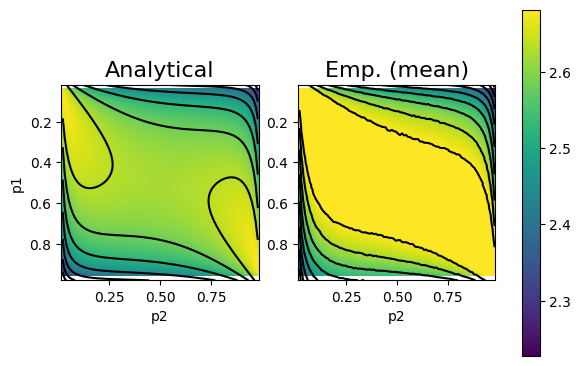

In [14]:
print(cur_eps)
amount_levs= 9

f,ax= plt.subplots(1,2,figsize=(7,4.5))






vmin_quarter=np.min([np.min(anal_res_quarter),np.min(np.mean(2*cur_eps*res[:,:,:,cur_eps_ind]))])
vmax_quarter=np.max([np.max(anal_res_quarter),np.max(np.mean(2*cur_eps*res[:,:,:,cur_eps_ind]))])

ax[0].imshow(anal_res_quarter,vmin=vmin_quarter,vmax=vmax_quarter,\
                   extent = [p2_quarter.flatten()[0],p2_quarter.flatten()[-1], p1_quarter.flatten()[-1], p1_quarter.flatten()[0]])
im2= ax[1].imshow(np.mean(2*cur_eps*res[:,:,:,cur_eps_ind],axis=-1),vmin=vmin_quarter,vmax=vmax_quarter,\
                   extent = [p2_quarter.flatten()[0],p2_quarter.flatten()[-1], p1_quarter.flatten()[-1], p1_quarter.flatten()[0]])


levels= np.log(np.linspace(np.exp(vmin_quarter), np.exp(vmax_quarter),amount_levs))

ax[0].contour(anal_res_quarter,levels=levels,\
                   extent = [p2_half.flatten()[0],p2_half.flatten()[-1], p1_half.flatten()[0], p1_half.flatten()[-1]],\
              vmin=vmin_quarter,vmax= vmax_quarter,colors='black')
ax[1].contour(np.mean(2*cur_eps*res[:,:,:,cur_eps_ind],axis=-1),levels=levels,\
                   extent = [p2_half.flatten()[0],p2_half.flatten()[-1], p1_half.flatten()[0], p1_half.flatten()[-1]],\
              colors='black')


cbar2 = plt.colorbar(im2, ax=ax, location='right')

for i in range(2):
    ax[i].set_xlabel('p2')
    
ax[0].set_ylabel('p1')


ax[0].set_title(r'Analytical',fontsize=16)
ax[1].set_title('Emp. (mean)',fontsize=16)
